# Julia for R-Lovers
## Demo: Sleepstudy LMM

In [1]:
using RCall;
using MixedModels;
using StatsBase, CSV, DataFrames;

R"""
library(tidyverse)
library(lme4) #package for doing linear mixed effects models in R
""";

┌ Warning: RCall.jl: Warning: replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’
│ ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
│ ✔ tibble  3.1.2     ✔ dplyr   1.0.0
│ ✔ tidyr   1.1.2     ✔ stringr 1.4.0
│ ✔ readr   1.3.1     ✔ forcats 0.5.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /Users/kylamcconnell/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: Matrix
│ 
│ Attaching package: ‘Matrix’
│ 
│ The following objects are masked from ‘package:tidyr’:
│ 
│     expand, pack, unpack
│ 
└ @ RCall /Users/kylamcconnell/.julia/packages/RCall/Qzssx/src/io.jl:160


### Sleep study data
- Dataset included in lme4 in R and MixedModels in Julia
- 18 participants restricted to 3 hours of sleep every night for 9 nights
- DV: average reaction time speed

- http://lme4.r-forge.r-project.org/slides/2011-01-11-Madison/2Longitudinal.pdf

### LMMs
- linear mixed effects models, add to linear regression the ability to account for random variance in repeated-measures designs (i.e., same participants or same items)
- lme4 package in R well-used in psychology, cognitive science, linguistics, etc. 
- lme4 models often fail to converge in R, requiring simplified model specification 
- takes a long time even when it does converge

In [2]:
sleep = DataFrame(MixedModels.dataset(:sleepstudy));

names(sleep)

3-element Array{String,1}:
 "subj"
 "days"
 "reaction"

In [3]:
first(sleep, 10)

,subj,days,reaction
,String,Int8,Float64
1,S308,0,249.56
2,S308,1,258.705
3,S308,2,250.801
4,S308,3,321.44
5,S308,4,356.852
6,S308,5,414.69
7,S308,6,382.204
8,S308,7,290.149
9,S308,8,430.585


In [4]:
describe(sleep)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,subj,,S308,,S372,18,,String
2,days,4.5,0,4.5,9,,,Int8
3,reaction,298.508,194.332,288.651,466.353,,,Float64


In [5]:
summarystats(sleep.reaction)

Summary Stats:
Length:         180
Missing Count:  0
Mean:           298.507892
Minimum:        194.332200
1st Quartile:   255.375825
Median:         288.650800
3rd Quartile:   336.752075
Maximum:        466.353500


In [6]:
@rput sleep;

In [7]:
R"""
sleep <- sleep %>%
  mutate(subj = as_factor(subj))

levels(sleep$subj)
"""

RObject{StrSxp}
 [1] "S308" "S309" "S310" "S330" "S331" "S332" "S333" "S334" "S335" "S337"
[11] "S349" "S350" "S351" "S352" "S369" "S370" "S371" "S372"


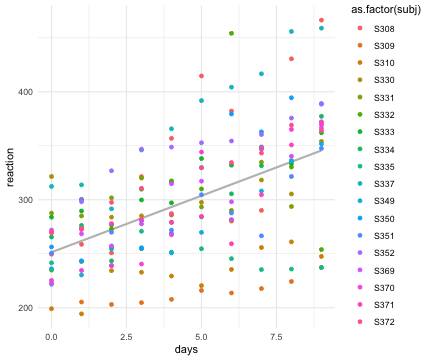

RObject{VecSxp}


┌ Warning: RCall.jl: `geom_smooth()` using formula 'y ~ x'
│ Warning: Width not defined. Set with `position_dodge(width = ?)`
└ @ RCall /Users/kylamcconnell/.julia/packages/RCall/Qzssx/src/io.jl:160


In [8]:
R"""
ggplot(sleep, aes(x= days, y = reaction)) +
  geom_smooth(method = "lm", color = "grey", se = F) +
  geom_point(aes(color = as.factor(subj)), position = "dodge") + 
  theme_minimal()
"""

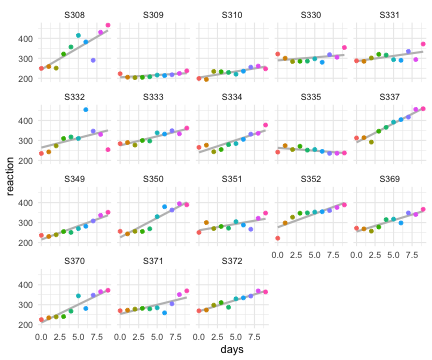

RObject{VecSxp}


┌ Warning: RCall.jl: `geom_smooth()` using formula 'y ~ x'
│ Warning: Width not defined. Set with `position_dodge(width = ?)`
└ @ RCall /Users/kylamcconnell/.julia/packages/RCall/Qzssx/src/io.jl:160


In [9]:
R"""
ggplot(sleep, aes(x= days, y = reaction)) +
  geom_smooth(method = "lm", color = "grey", se = F) +
  geom_point(aes(color = as.factor(days)), position = "dodge", show.legend = FALSE) +
  facet_wrap(~subj) + 
  theme_minimal()
"""

In [10]:
@rget sleep;

In [11]:
typeof(sleep.subj)

CategoricalArray{String,1,UInt32,String,CategoricalValue{String,UInt32},Union{}}

LMM formula (similar to R)
Regression syntax
    - DV ~ predictors
Random effect term: 
    - accounts for difference by subj
    - random intercepts (y-axis location)
    - random slope 
    - (1 + predictor | subj)
    
 - In this case MixedModel syntax is similar to R:
     lmer(reaction ~ days + (1 + days | subj))

In [12]:
formula_sleep = @formula (reaction ~ days + (1 + days | subj));

In [13]:
sleep_model = fit(MixedModel, formula_sleep, sleep);

In [14]:
show(sleep_model)

Linear mixed model fit by maximum likelihood
 reaction ~ 1 + days + (1 + days | subj)
   logLik   -2 logLik     AIC       AICc        BIC    
  -875.9697  1751.9393  1763.9393  1764.4249  1783.0971

Variance components:
            Column    Variance Std.Dev.   Corr.
subj     (Intercept)  565.51069 23.78047
         days          32.68212  5.71683 +0.08
Residual              654.94145 25.59182
 Number of obs: 180; levels of grouping factors: 18

  Fixed-effects parameters:
──────────────────────────────────────────────────
                Coef.  Std. Error      z  Pr(>|z|)
──────────────────────────────────────────────────
(Intercept)  251.405      6.63226  37.91    <1e-99
days          10.4673     1.50224   6.97    <1e-11
──────────────────────────────────────────────────

### Example
formula_maximal_ftp = @formula (DV  ~ f_1 * f_2 * f_3 * f_4 + c_1 + c_2 + c_3 + c_4 + c_5 +
               (1 + f_1 + c_1 + c_2 + c_3 + c_4 | id) + 
               (1 + c_1 + f_2 * f_3 | item_1) +
               (1 + c_1 + f_2 * f_3 | item_2));

### Coding categorical predictors
cntrsts = merge(
    Dict(:cond => EffectsCoding(base="cond_A"),
         :education => HelmertCoding(levels=["High school", "Undergraduate", "Grad school"]),
         :id => Grouping(),
         :item => Grouping())
);

sleep_model = fit(MixedModel, formula_sleep, sleep, contrasts = cntrsts);

In [15]:
using JellyMe4 #companion to lme4 / MixedModels and RCall

sleep_model_R = (sleep_model, sleep)

@rput sleep_model_R

(Linear mixed model fit by maximum likelihood
 reaction ~ 1 + days + (1 + days | subj)
   logLik   -2 logLik     AIC       AICc        BIC    
  -875.9697  1751.9393  1763.9393  1764.4249  1783.0971

Variance components:
            Column    Variance Std.Dev.   Corr.
subj     (Intercept)  565.51069 23.78047
         days          32.68212  5.71683 +0.08
Residual              654.94145 25.59182
 Number of obs: 180; levels of grouping factors: 18

  Fixed-effects parameters:
──────────────────────────────────────────────────
                Coef.  Std. Error      z  Pr(>|z|)
──────────────────────────────────────────────────
(Intercept)  251.405      6.63226  37.91    <1e-99
days          10.4673     1.50224   6.97    <1e-11
──────────────────────────────────────────────────, 180×3 DataFrame
│ Row │ subj │ days  │ reaction │
│     │ Cat… │ Int64 │ Float64  │
├─────┼──────┼───────┼──────────┤
│ 1   │ S308 │ 0     │ 249.56   │
│ 2   │ S308 │ 1     │ 258.705  │
│ 3   │ S308 │ 2     │ 250.8

Not enough model terms in the conditional part of the model to check for multicollinearity.


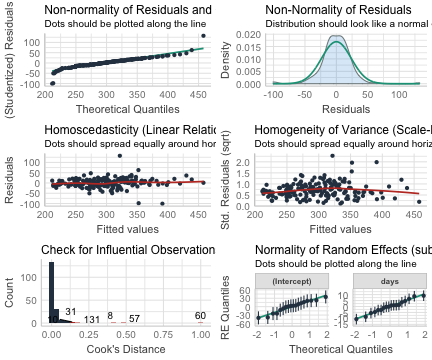

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: `guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.
│ `geom_smooth()` using formula 'y ~ x'
│ `geom_smooth()` using formula 'y ~ x'
│ `geom_smooth()` using formula 'y ~ x'
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ Warning: Removed 174 rows containing missing values (geom_text_repel).
│ `geom_smooth()` using formula 'y ~ x'
└ @ RCall /Users/kylamcconnell/.julia/packages/RCall/Qzssx/src/io.jl:160


In [16]:
R"""
library(performance)
check_model(sleep_model_R)
"""

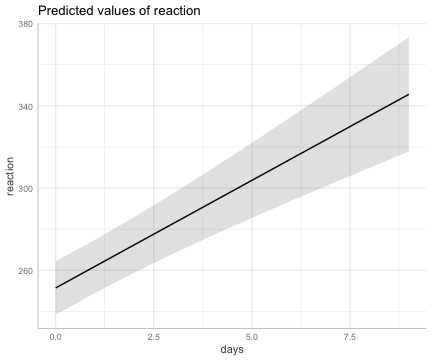

RObject{VecSxp}


In [17]:
R"""
library(ggeffects)
plot(ggpredict(sleep_model_R, terms = "days")) 
"""

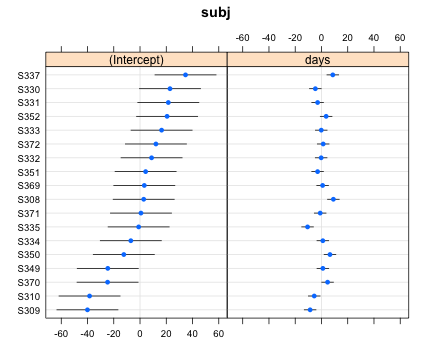

RObject{VecSxp}
$subj



In [18]:
R"""
library(lattice)

dotplot(ranef(sleep_model_R))
"""

Things to look out for:
- missing values may be treated differently
    - easy solution: remove NAs in R in advance
- changes in packages, especially "younger" ones
    - may have to be creative with package management 
- may be less on Stack Overflow 